In [7]:
import numpy as np

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [9]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)
X, y = mnist.data, mnist.target

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
# will generate as many PC as features

pca = PCA()
pca.fit(X_train)

PCA()

In [12]:
# we lower to d dimentions such that 95 % of variance remained
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [13]:
d

154

In [14]:
# or automatically
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

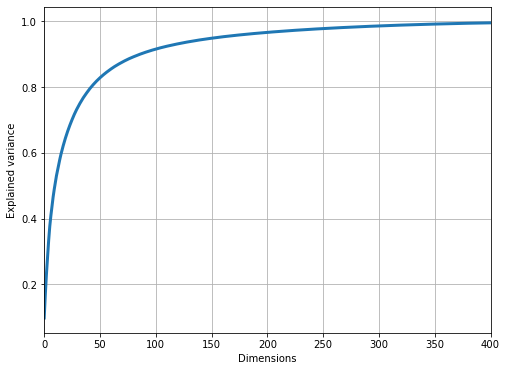

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(cumsum, linewidth=3)
plt.xlabel("Dimensions")
plt.ylabel("Explained variance")
plt.grid(True)
plt.xlim(0, 400)
plt.show()

In [16]:
# go back to original size (note: lost variance won't be back)
X_recovered = pca.inverse_transform(X_reduced)

In [17]:
X_recovered.shape

(56000, 784)

In [18]:
# incremental PCA
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

In [19]:
# kernel PCA
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [20]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

In [21]:
y = t > 6.9

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# finding best kernel options for performance
clf = Pipeline([
    ("kpca", KernelPCA(n_components=2, n_jobs=-1)),
    ("log_reg", LogisticRegression(n_jobs=-1))
])

param = {
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}

grid = GridSearchCV(clf, param, cv=3, n_jobs=-1)
grid.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca',
                                        KernelPCA(n_components=2, n_jobs=-1)),
                                       ('log_reg',
                                        LogisticRegression(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                         'kpca__kernel': ['rbf', 'sigmoid']})

In [23]:
grid.best_params_

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

In [24]:
rbf_pca = KernelPCA(n_components=2, fit_inverse_transform=True, gamma=0.043333333, kernel="rbf")
X_reduced = rbf_pca.fit_transform(X)
X_preimg = rbf_pca.inverse_transform(X_reduced)

In [25]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimg)

# we want to mimnimalise it 

32.79523569805007

In [26]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)

In [27]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced = mds.fit_transform(X)

In [28]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced = isomap.fit_transform(X)

In [29]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

/opt/homebrew/Caskroom/miniforge/base/envs/ML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X = mnist.data
y = mnist.target

lds = LinearDiscriminantAnalysis(n_components=2)
lds.fit(X, y)
X_reduced = lds.transform(X)

# Exerices

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

from sklearn.ensemble import RandomForestClassifier

rnd_for = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
rnd_for.fit(X_train, y_train)

kpca = KernelPCA(kernel="rbf", n_components=0.95, n_jobs=-1)
X_reduced = kpca.fit_transform(X_train)

from sklearn.base import clone


rnd_for2 = clone(rnd_for)
rnd_for2.fit(X_reduced, y_train)

In [31]:
np.random.seed(42)
m = 10000
idx = np.random.permutation(60000)[:m]

X = X[idx]
y = y[idx]

In [32]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

/opt/homebrew/Caskroom/miniforge/base/envs/ML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


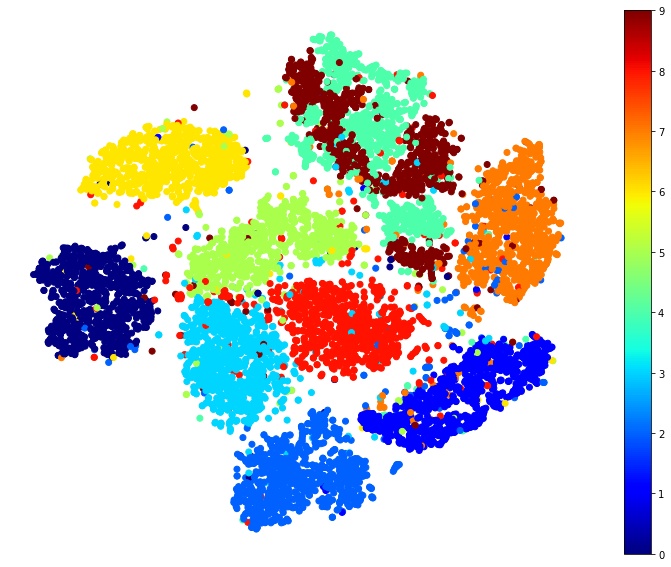

In [36]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y.astype(np.uint8), cmap="jet")
plt.axis("off")
plt.colorbar()
plt.show()

In [ ]:
# more
# https://github.com/ageron/handson-ml2/blob/master/08_dimensionality_reduction.ipynb